In [5]:
# -*- coding: utf-8 -*- 
# @Time : 2022/3/18 14:18 
# @Author : Orange
# @File : g_pred.py.py

# -*- coding: utf-8 -*- 
# @Time : 2022/3/18 14:18 
# @Author : Orange
# @File : g_pred.py.py

from decimal import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime

In [2]:
class GM11():
    def __init__(self):
        self.f = None

    def isUsable(self, X0):
        '''判断是否通过光滑检验'''
        X1 = X0.cumsum()
        rho = [X0[i] / X1[i - 1] for i in range(1, len(X0))]
        rho_ratio = [rho[i + 1] / rho[i] for i in range(len(rho) - 1)]
        print(rho, rho_ratio)
        flag = True
        for i in range(2, len(rho) - 1):
            if rho[i] > 0.5 or rho[i + 1] / rho[i] >= 1:
                flag = False
        if rho[-1] > 0.5:
            flag = False
        if flag:
            print("数据通过光滑校验")
        else:
            print("该数据未通过光滑校验")

        '''判断是否通过级比检验'''
        lambds = [X0[i - 1] / X0[i] for i in range(1, len(X0))]
        X_min = np.e ** (-2 / (len(X0) + 1))
        X_max = np.e ** (2 / (len(X0) + 1))
        for lambd in lambds:
            if lambd < X_min or lambd > X_max:
                print('该数据未通过级比检验')
                return
        print('该数据通过级比检验')

    def train(self, X0):
        X1 = X0.cumsum(axis=0)  # [x_2^1,x_3^1,...,x_n^1,x_1^1] # 其中x_i^1为x_i^01次累加后的列向量
        Z = (np.array([-0.5 * (X1[:, -1][k - 1] + X1[:, -1][k]) for k in range(1, len(X1[:, -1]))])).reshape(
            len(X1[:, -1]) - 1, 1)
        # 数据矩阵A、B
        A = (X0[:, -1][1:]).reshape(len(Z), 1)
        B = np.hstack((Z, X1[1:, :-1]))
        # 求参数
        u = np.linalg.inv(np.matmul(B.T, B)).dot(B.T).dot(A)
        a = u[0][0]
        b = u[1:]
        print("灰参数a：", a, "，参数矩阵b：", b)
        self.f = lambda k, X1: (X0[0, -1] - (1 / a) * (X1[k, ::]).dot(b)) * np.exp(-a * k) + (1 / a) * (X1[k, ::]).dot(
            b)

    def predict(self, k, X0):
        '''
        :param k: k为预测的第k个值
        :param X0: X0为【k*n】的矩阵,n为特征的个数，k为样本的个数
        :return:
        '''
        X1 = X0.cumsum(axis=0)
        X1_hat = [float(self.f(k, X1)) for k in range(k)]
        X0_hat = np.diff(X1_hat)
        X0_hat = np.hstack((X1_hat[0], X0_hat))
        return X0_hat

    def evaluate(self, X0_hat, X0):
        '''
        根据后验差比及小误差概率判断预测结果
        :param X0_hat: 预测结果
        :return:
        '''
        S1 = np.std(X0, ddof=1)  # 原始数据样本标准差
        S2 = np.std(X0 - X0_hat, ddof=1)  # 残差数据样本标准差
        C = S2 / S1  # 后验差比
        Pe = np.mean(X0 - X0_hat)
        temp = np.abs((X0 - X0_hat - Pe)) < 0.6745 * S1
        p = np.count_nonzero(temp) / len(X0)  # 计算小误差概率
        print("原数据样本标准差：", S1)
        print("残差样本标准差：", S2)
        print("后验差：", C)
        print("小误差概率p：", p)

In [3]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 步骤一（替换sans-serif字体）
plt.rcParams['axes.unicode_minus'] = False  # 步骤二（解决坐标轴负数的负号显示问题）
data = pd.read_csv(r"data/data.csv")

In [4]:
data

,年份,城区人口,建成区面积,供水总量,用水人口,人口综合用水指标,城市用水总量
0,2002,191.85,98.00,26396.00,150.10,175.86,33737.99
1,2003,195.96,98.00,25551.00,150.10,170.23,33357.59
2,2004,203.37,98.00,32661.00,200.00,163.31,33211.34
3,2005,206.31,129.00,24186.00,203.00,119.14,24580.36
4,2006,257.45,132.00,27194.00,208.33,130.53,33605.80
5,2007,217.27,132.00,24134.80,178.88,134.92,29314.45
6,2008,217.27,132.00,24427.20,203.00,120.33,26144.32
7,2009,217.27,175.00,23932.92,207.30,115.45,25083.96
8,2010,217.39,162.00,24397.00,209.18,116.63,25354.55
9,2011,251.00,162.00,25238.82,224.26,112.54,28248.21


# 0. 读取数据

In [6]:
def change_date(s):
    s = datetime.datetime.strptime(s, "%Y-%m")  # 把日期标准化，转化结果如：2015/1/4 => 2015-01-04 00:00:00
    s = str(s)  # 上一步把date转化为了时间格式，因此要把date转回str格式
    return s[:7] # 只获取年月日，即“位置7”之前的字符串

In [7]:
#含水量日期排序
df1 = pd.read_csv('data/fj3.csv')
df1['日期'] = df1['年份'].map(str)+"-"+df1['月份'].map(str)
df1['日期'] = df1['日期'].map(change_date)
df1 = df1.sort_values(by='日期') 
df1.head(5)

,月份,年份,经度(lon),纬度(lat),10cm湿度(kg/m2),40cm湿度(kg/m2),100cm湿度(kg/m2),200cm湿度(kg/m2),日期
111,1,2012,115.375,44.125,13.73,30.87,42.79,168.56,2012-01
112,2,2012,115.375,44.125,13.00,30.87,42.79,168.56,2012-02
113,3,2012,115.375,44.125,12.60,30.87,42.79,168.56,2012-03
114,4,2012,115.375,44.125,11.97,30.73,42.76,168.56,2012-04
115,5,2012,115.375,44.125,14.18,29.99,42.58,168.56,2012-05


In [8]:
df3 = pd.read_csv('data/fj4.csv')
df3['日期'] = df3['年份'].map(str)+"-"+df3['月份'].map(str)
df3['日期'] = df3['日期'].map(change_date)
df3 = df3.sort_values(by='日期')
df3.head(5)

,月份,年份,经度(lon),纬度(lat),土壤蒸发量(W/m2),土壤蒸发量(mm),Unnamed: 6,Unnamed: 7,日期
111,1,2012,115.375,44.125,0.57,0.61,NaN,NaN,2012-01
112,2,2012,115.375,44.125,0.86,0.86,NaN,NaN,2012-02
113,3,2012,115.375,44.125,1.78,1.91,NaN,NaN,2012-03
114,4,2012,115.375,44.125,6.94,7.20,NaN,NaN,2012-04
115,5,2012,115.375,44.125,16.89,18.10,NaN,NaN,2012-05


In [9]:
df4 = pd.read_csv('data/fj6.csv')
df4['日期'] = df4['年份'].map(str)+"-"+df4['月份'].map(str)
df4['日期'] = df4['日期'].map(change_date)
df4 = df4.sort_values(by='日期')
df4.head(5)

,月份,年份,经度(lon),纬度(lat),植被指数(NDVI),Unnamed: 5,Unnamed: 6,日期
112,1,2012,115.375,44.125,0.002,NaN,NaN,2012-01
113,2,2012,115.375,44.125,0.002,NaN,NaN,2012-02
114,3,2012,115.375,44.125,0.120,NaN,NaN,2012-03
115,4,2012,115.375,44.125,0.168,NaN,NaN,2012-04
116,5,2012,115.375,44.125,0.195,NaN,NaN,2012-05


In [10]:
df5 = pd.read_csv('data/fj9.csv')
df5['日期'] = df5['年份'].map(str)+"-"+df5['月份'].map(str)
df5['日期'] = df5['日期'].map(change_date)
df5 = df5.sort_values(by='日期')
df5.head(5)

,月份,年份,经度(lon),纬度(lat),径流量(m3/s),径流量(m3),Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,日期
111,1,2012,115.375,44.125,0.000000,0.0,NaN,NaN,NaN,NaN,2012-01
112,2,2012,115.375,44.125,0.000000,0.0,NaN,NaN,NaN,NaN,2012-02
113,3,2012,115.375,44.125,1.010081,2705400.0,NaN,NaN,NaN,NaN,2012-03
114,4,2012,115.375,44.125,0.569792,1476900.0,NaN,NaN,NaN,NaN,2012-04
115,5,2012,115.375,44.125,0.168347,450900.0,NaN,NaN,NaN,NaN,2012-05


In [11]:
df6 = pd.read_csv('data/fj10.csv')
df6 = df6.sort_values(by='日期')
df6.head(5)

,日期,经度(lon),纬度(lat),"高层植被(LAIH,m2/m2)","低层植被(LAIL,m2/m2)",Unnamed: 5
115,201201,115.375,44.125,0.0,0.636,NaN
116,201202,115.375,44.125,0.0,0.652,NaN
117,201203,115.375,44.125,0.0,0.717,NaN
118,201204,115.375,44.125,0.0,0.727,NaN
119,201205,115.375,44.125,0.0,0.739,NaN


In [12]:
df = df1.drop(['月份', '年份','经度(lon)', '纬度(lat)'], axis = 1)
df.head(5)

,10cm湿度(kg/m2),40cm湿度(kg/m2),100cm湿度(kg/m2),200cm湿度(kg/m2),日期
111,13.73,30.87,42.79,168.56,2012-01
112,13.00,30.87,42.79,168.56,2012-02
113,12.60,30.87,42.79,168.56,2012-03
114,11.97,30.73,42.76,168.56,2012-04
115,14.18,29.99,42.58,168.56,2012-05


In [13]:
df7 = pd.read_csv('data/降水量.csv')
df7.head(5)

,降水量(mm)
0,2.29
1,2.29
2,21.84
3,6.10
4,50.80


In [14]:
#组合表格，便于数据读取
df0 = df.join(df3['土壤蒸发量(W/m2)'])
df0 = df0.join(df4['植被指数(NDVI)'])
df0 = df0.join(df5['径流量(m3/s)'])
df0 = df0.join(df6['低层植被(LAIL,m2/m2)'])
df0 = df0.join(df7['降水量(mm)'])
df0 = df0[['日期', '降水量(mm)','土壤蒸发量(W/m2)', '植被指数(NDVI)', '径流量(m3/s)', '低层植被(LAIL,m2/m2)','10cm湿度(kg/m2)','40cm湿度(kg/m2)','100cm湿度(kg/m2)','200cm湿度(kg/m2)']]
df0.head(5)

,日期,降水量(mm),土壤蒸发量(W/m2),植被指数(NDVI),径流量(m3/s),"低层植被(LAIL,m2/m2)",10cm湿度(kg/m2),40cm湿度(kg/m2),100cm湿度(kg/m2),200cm湿度(kg/m2)
111,2012-01,10.67,0.57,0.211,0.000000,0.847,13.73,30.87,42.79,168.56
112,2012-02,17.78,0.86,0.002,0.000000,0.738,13.00,30.87,42.79,168.56
113,2012-03,52.07,1.78,0.002,1.010081,0.710,12.60,30.87,42.79,168.56
114,2012-04,134.37,6.94,0.120,0.569792,0.648,11.97,30.73,42.76,168.56
115,2012-05,37.34,16.89,0.168,0.168347,0.636,14.18,29.99,42.58,168.56


# 1. 10cm

In [22]:
df1 = df0[['降水量(mm)','土壤蒸发量(W/m2)', '植被指数(NDVI)', '径流量(m3/s)', '低层植被(LAIL,m2/m2)','10cm湿度(kg/m2)']]
df1

,降水量(mm),土壤蒸发量(W/m2),植被指数(NDVI),径流量(m3/s),"低层植被(LAIL,m2/m2)",10cm湿度(kg/m2)
111,10.67,0.57,0.211,0.000000,0.84700,13.73
112,17.78,0.86,0.002,0.000000,0.73800,13.00
113,52.07,1.78,0.002,1.010081,0.71000,12.60
114,134.37,6.94,0.120,0.569792,0.64800,11.97
115,37.34,16.89,0.168,0.168347,0.63600,14.18
...,...,...,...,...,...,...
13,2.79,1.39,0.325,0.295573,0.96400,13.91
14,9.14,0.87,0.239,0.217238,0.98300,13.14
0,2.29,0.41,0.010,0.160786,0.63638,12.45
1,2.29,0.28,0.010,0.116071,0.65073,12.10


In [23]:
X = df1.values
# 训练集
X_train = X[:, :]
# 测试集
X_test = []

In [24]:
model = GM11()
model.isUsable(X_train[:, -1])  # 判断模型可行性

[0.9468317552804079, 0.47138047138047134, 0.30434782608695654, 0.2764132553606238, 0.29444105070250465, 0.23171307220386977, 0.15095785440613027, 0.14247669773635155, 0.10955710955710955, 0.09709821428571429, 0.08629046735683084, 0.07761802456894179, 0.06926694612002864, 0.06143328393173017, 0.053238446986757955, 0.05443893260348957, 0.07807113598572414, 0.07651794447370402, 0.06153899916130837, 0.047700562925897895, 0.04260667378872621, 0.03592309083237901, 0.031942747425379656, 0.02974176815516464, 0.027294877761655765, 0.03720285683829016, 0.03982528263103803, 0.04133926365208797, 0.043399852881854634, 0.03797871372691713, 0.032535822268962795, 0.027245528041250237, 0.03094338063663217, 0.027490031857981524, 0.022873968916362782, 0.021294848819918402, 0.020104160833286665, 0.018170838823012736, 0.027515680882802252, 0.02544952074442035, 0.02868985279819879, 0.02840372083768592, 0.02494276224565477, 0.02723025374003052, 0.02381316998468607, 0.021763518061476337, 0.021563460693895482,

In [25]:
model.train(X_train)  # 训练

灰参数a： 0.028399761562109486 ，参数矩阵b： [[ 3.06378502e-03]
 [ 1.21852801e-01]
 [-8.24155191e+00]
 [ 3.90335561e+00]
 [ 2.28860642e-02]]


In [26]:
Y_pred = model.predict(len(X), X[:, :-1])  # 预测
Y_pred

array([ 13.73      ,  -1.82170032,   6.62637456,   9.51224535,
        10.02652798,  21.44354218,  21.40965447,  18.53249807,
         3.70832733,  12.21087031,  21.75541959,   8.62412022,
         0.28839807,  16.07376188,  26.29572887,  20.85575024,
        23.06466365,  64.42131857,  40.85481184,  32.97676651,
        -3.02230222,  -7.52703325,   7.44030859,  -1.36933806,
        18.26476348,  -9.55851678,  46.66845498,  42.88668113,
        62.69542863,  71.10617186,  41.60931251,  -7.99377743,
       -14.62679586,  -4.16504549,  -6.19174202, -12.45803203,
       -16.91331565,   5.16313616,  25.80041564, 104.49285019,
        44.66799228,  65.28137986,  22.87438094,   1.32067031,
       -10.5922129 ,  -3.54163959,   1.08212139, -13.56830016,
        15.71100688,  19.75260606, 108.10540063,   7.57703294,
        63.62662224,  65.25596298,  47.57765734,  -6.65173226,
         3.76063085,  65.02995034,  30.38829431,  -8.07470573,
       -19.88756951,  16.33945523,  -3.51601941,  49.26

In [27]:
Y_train_pred = Y_pred[:len(X_train)]
Y_test_pred = Y_pred[len(X_train):]
score_tRAIN = model.evaluate(Y_train_pred, X_train[:, -1])  # 评估

原数据样本标准差： 2.849444528269582
残差样本标准差： 39.53250882752445
后验差： 13.873759757496265
小误差概率p： 0.04878048780487805


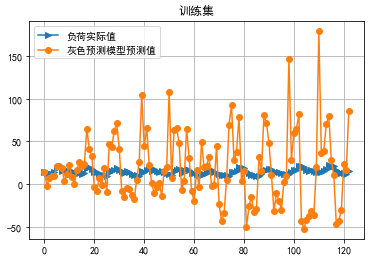

In [28]:
# 可视化
plt.grid()
plt.plot(np.arange(len(Y_train_pred)), X_train[:, -1], '->')
plt.plot(np.arange(len(Y_train_pred)), Y_train_pred, '-o')
plt.legend(['负荷实际值', '灰色预测模型预测值'])
plt.title('训练集')
plt.show()

xi [[ 104.    205.8   311.6   423.1   539.07  659.1   772.4   888.8   993.9
  1077.3  1150.6 ]
 [ 135.6   275.8   415.9   562.8   706.8   849.8   983.1  1118.8  1244.6
  1343.1  1442.9 ]
 [ 131.6   267.1   409.7   552.9   695.1   833.5   971.9  1106.9  1229.4
  1316.6  1413.1 ]
 [  54.2   109.1   163.9   220.2   274.7   329.3   384.2   439.    488.3
   529.8   578.7 ]]
Y.shape: (10, 1)
B.shape: (10, 1)
X.shape: (10, 4)
B-final: (10, 5)
[[ 3407.51953809 -3843.50637897 -4081.15072432 29777.99766297]]
b.shape: (1, 4)
第 0 行 第 0 列 104.0
第 1 行 第 0 列 135.6
第 2 行 第 0 列 131.6
第 3 行 第 0 列 54.2
910090.6049853668
第 0 行 第 1 列 205.8
第 1 行 第 1 列 275.79999999999995
第 2 行 第 1 列 267.1
第 3 行 第 1 列 109.1
1799932.6481828797
第 0 行 第 2 列 311.6
第 1 行 第 2 列 415.9
第 2 行 第 2 列 409.70000000000005
第 3 行 第 2 列 163.89999999999998
2671835.1502616894
第 0 行 第 3 列 423.1
第 1 行 第 3 列 562.8
第 2 行 第 3 列 552.9000000000001
第 3 行 第 3 列 220.2
3579242.9763904773
第 0 行 第 4 列 539.07
第 1 行 第 4 列 706.8
第 2 行 第 4 列 695.1000000000001


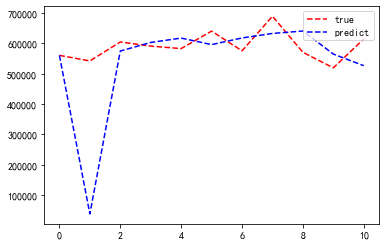

In [31]:
import numpy as np
import math as mt
import matplotlib.pyplot as plt
# 1.这里我们将 a 作为我们的特征序列 x0,x1,x2,x3作为我们的相关因素序列
a = [560823,542386,604834,591248,583031,640636,575688,689637,570790,519574,614677];
x0 = [104,101.8,105.8,111.5,115.97,120.03,113.3,116.4,105.1,83.4,73.3]
x1 = [135.6,140.2,140.1,146.9,144,143,133.3,135.7,125.8,98.5,99.8]
x2 = [131.6,135.5,142.6,143.2,142.2,138.4,138.4,135,122.5,87.2,96.5]
x3 = [54.2,54.9,54.8,56.3,54.5,54.6,54.9,54.8,49.3,41.5,48.9]
 
# 2.我们对其进行一次累加
def AGO(m):
    m_ago = [m[0]]
    add = m[0] + m[1]
    m_ago.append(add)
    i = 2
    while i < len(m):
        # print("a[",i,"]",a[i])
        add = add+m[i]
        # print("->",add)
        m_ago.append(add)
        i += 1
    return m_ago
 
a_ago = AGO(a)
x0_ago = AGO(x0)
 
x1_ago = AGO(x1)
x2_ago = AGO(x2)
x3_ago = AGO(x3)
 
xi = np.array([x0_ago,x1_ago,x2_ago,x3_ago])
print("xi",xi)
 
 
# 3.紧邻均值生成序列
def JingLing(m):
    Z = []
    j = 1
    while j < len(m):
        num = (m[j]+m[j-1])/2
        Z.append(num)
        j = j+1
    return Z
Z = JingLing(a_ago)
# print(Z)
 
# 4.求我们相关参数
Y = []
x_i = 0
while x_i < len(a)-1 :
    x_i += 1
    Y.append(a[x_i])
Y = np.mat(Y).T
Y.reshape(-1,1)
print("Y.shape:",Y.shape)
 
B = []
b = 0
while b < len(Z) :
    B.append(-Z[b])
    b += 1
B = np.mat(B)
B.reshape(-1,1)
B = B.T
print("B.shape:",B.shape)
X = xi[:,1:].T
print("X.shape:",X.shape)
B = np.hstack((B,X))
print("B-final:",B.shape)
 
# 可以求出我们的参数
theat = np.linalg.inv(B.T.dot(B)).dot(B.T).dot(Y)
# print(theat)
al = theat[:1,:]
al = float(al)
# print("jhjhkjhjk",float(al))
b = theat[1:,:].T
print(b)
print("b.shape:",b.shape)
b = list(np.array(b).flatten())
 
 
# 6.生成我们的预测模型
U = []
k = 0
i = 0
# 计算驱动值
for k in range(11):
    sum1 = 0
    for i in range(4):
        sum1 += b[i] * xi[i][k]
        print("第",i,"行","第",k,'列',xi[i][k])
        i += 1
    print(sum1)
    U.append(sum1)
    k += 1
print("U:",U)
 
# 计算完整公式的值
F = []
F.append(a[0])
 
f = 1
while f < len(a):
    F.append((a[0]-U[f-1]/al)/mt.exp(al*f)+U[f-1]/al)
    f += 1
print("F",)
 
# 做差序列
G = []
G.append(a[0])
g = 1
while g<len(a):
    G.append(F[g]-F[g-1])
    g +=1
print("G:",G)
 
r = range(11)
t = list(r)
 
plt.plot(t,a,color='r',linestyle="--",label='true')
plt.plot(t,G,color='b',linestyle="--",label="predict")
plt.legend(loc='upper right')
plt.show()
 

In [3]:
import re
import numpy as np


def summed_array(arr):
    a = np.zeros(arr.shape)
    for i in range(arr.shape[0]):
        s = 0
        for j in range(arr.shape[1]):
            s += arr[i, j]
            a[i, j] = s
    return a


def gen_list(first, start, end, arr, index_delta, P, X0, *thetas):
    a = [first]
    t1, t2, t3, t4 = thetas
    for k in range(start, end):
        s1 = s2 = 0
        for u in range(k - 1):
            for i in range(1, X0.shape[0]):
                s1 += t1 * t2 ** u * P[i - 1] * arr[i - index_delta, k - u]
        s2 = sum(t2 ** v * ((k - v + 1) * t3 + t4) for v in range(k - 1))
        s3 = t2 ** k * X0[0, 0]
        a.append(s1 + s2 + s3)
    return a


def matlab_string_to_array(s):
    ss = s.strip().strip('[]').split(';')
    a = [[float(i) for i in re.findall(r'[-0-9.]+', j)] for j in ss]
    return np.array(a)


def main():
    print("OBGM(1, N)模型:")
    # tip0 = "請輸入因變量序列(第一個分號前面部分)與自變量序列(多個自變量序列之間用分號隔開)，如：[1 2 3;4 5 6]\n:"
    # tip00 = "請輸入預測時的自變量序列(多個自變量序列之間用分號隔開)，如：[911 12 13]\n:"
    # try:
    #     X0, X00 = [matlab_string_to_array(raw_input(t)) for t in (tip0, tip00)]
    # except NameError:
    #     X0, X00 = [matlab_string_to_array(input(t)) for t in (tip0, tip00)]
    
    # 書上的數據
    X0 = [
        [287.6, 312.8, 350.4, 401.9, 480.9, 498.3, 520, 543.7],
        [19978, 21989, 24725, 26738, 29073, 32903, 36469, 40321],
        [3371.5, 3966.6, 3748.5, 4858.4, 5493.5, 5910.6, 6462.8, 7032.2],
        [1848.5, 2053.3, 2131.7, 2303.1, 2764, 3048.8, 3294.3, 3566.4],
    ]
    X00 = [[43910], [7562.3], [3746.8]]
    X0 = np.array(X0)
    X00 = np.array(X00)
    

    epsilon = 0.5
    n, m = X0.shape
    F = summed_array(X0)

    # Calculate mode parameters
    Y = X0[0][1:].T
    B = np.delete(F.T[1:], 0, axis=1)
    Bm = [
        (epsilon - 1) * F[0, k] - epsilon * F[0, k + 1] for k in range(m - 1)
    ]
    Li = [k + 2 for k in range(m - 1)]
    Co = [1] * (m - 1)
    for L in (Bm, Li, Co):
        B = np.c_[B, np.array(L).T]

    # Calculate b2,b3,...
    P = np.linalg.inv(B.T.dot(B)).dot(B.T).dot(Y)
    in_var_number = n - 1
    a, c, d = P[in_var_number: in_var_number + 3]

    t = 1 + epsilon * a
    thetas = (1 / t, 1 - a / t, c / t, d / t)

    # Calculate Simu
    Simu1 = gen_list(X0[0, 0], 1, m, F, 0, P, X0, *thetas)

    # Calcute g
    Xf = X0[1:]
    X0_F = np.c_[Xf, X00]
    X0_F_1 = summed_array(X0_F)
    Fore1 = gen_list(F[0, m - 1], m, X0_F.shape[1], X0_F_1, 1, P, X0, *thetas)
    Fore0 = [round(a - b, 3) for a, b in zip(Fore1[1:], Fore1[:-1])]

    # A
    A = np.zeros((n, 5))
    A[0, 0] = 1
    A[0, 1] = A[0, 2] = X0[0, 0]

    # mp
    mp = 0
    for k in range(1, len(X0)):
        A[k, 0] = k + 1
        A[k, 1] = X0[0, k]
        A[k, 2] = round(Simu1[k] - Simu1[k - 1], 3)
        A[k, 3] = round(A[k, 2] - A[k, 1], 3)
        A[k, 4] = round(100 * abs(A[k, 3]) / A[k, 1], 3)
        mp += 100 * abs(A[k, 3]) / A[k, 1]
    mp = round(mp / (len(X0) - 1), 4)

    print("-" * 20)
    print("(1)模型參數b2,b3,..,bn及a,c,d分別為:")
    print(np.around(P, 6))

    print("\n(2)誤差檢驗表為:")
    print("   序號    實際數據    模擬數據    殘差    相對誤差(%)")
    print(A)

    print("\n(3)平均相對模擬百分誤差為(%)")
    print(mp)

    print("\n(4)未來[{}]步的預測值分別為:".format(len(Fore0)))
    print(Fore0)


if __name__ == "__main__":
    main()

OBGM(1, N)模型:
--------------------
(1)模型參數b2,b3,..,bn及a,c,d分別為:
[-2.67660000e-02  8.95220000e-02  3.78525000e-01  2.16535000e+00
  2.74942269e+02 -2.86240806e+02]

(2)誤差檢驗表為:
   序號    實際數據    模擬數據    殘差    相對誤差(%)
[[   1.     287.6    287.6      0.       0.   ]
 [   2.     312.8   -299.017 -611.817  195.594]
 [   3.     350.4    986.505  636.105  181.537]
 [   4.     401.9    376.647  -25.253    6.283]]

(3)平均相對模擬百分誤差為(%)
127.8046

(4)未來[1]步的預測值分別為:
[552.14]
